In [2]:
import math

import numpy as np

from scipy.optimize import minimize


class Model:
    rho = 1.25

    def __init__(self, induced_matrix, stations, speed, alpha, sweep, span, chord, fatness, twist, billow,
                 moment_coeff):
        # TODO instead of constant span stations, have more near the tips, equal theta spacing
        # check roughly convergence of results vs number of stations
        self.induced_matrix = induced_matrix
        self.stations = stations
        self.speed = speed
        self.alpha = alpha
        self.sweep = sweep
        self.span = span
        self.chord = chord
        self.fatness = fatness
        self.twist = twist
        self.billow = billow
        self.moment_coeff = moment_coeff
        self.circulations = self.solve_circulations()

    def lift(self):
        return (self.circulations * self.widths()).sum() * self.speed * self.rho

    def induced_drag(self):
        return (self.circulations * self.widths() * self.induced_normalwash()).sum() * self.rho

    def moment(self):
        return self.moment_and_aero_center()[0]

    def moment_and_aero_center(self):
        # revisit this and check moment around the x axis for non-planar wings
        # revisit and include airfoil section moment
        dcdaw = self.d_circulations_d_alpha_rad() * self.widths()
        distances = self.vortex_pts_mid()[:, 0]
        center = (dcdaw * distances).sum() / dcdaw.sum()
        varying_moment = (self.circulations * self.widths() * (distances - center)).sum() * self.speed * self.rho
        q = self.sq(self.speed) * self.rho / 2
        fixed_moment = (self.widths() * self.sq(self.chords())).sum() * self.moment_coeff * q
        return (varying_moment + fixed_moment), center

    def d_circulations_d_alpha_rad(self):
        d_vel_d_alpha_rad = np.ones((self.stations * 2,)) * self.speed
        return np.linalg.solve(
            self.influence_matrix(),
            d_vel_d_alpha_rad)

    def skin_friction_drag_estimate(self):
        c = 0.01
        return self.rho / 2 * self.speed * self.speed * self.area() * c

    def total_drag_estimate(self):
        return self.induced_drag() + self.skin_friction_drag_estimate()

    def induced_normalwash(self):
        return self.induced_matrix(self).dot(self.circulations)

    def effective_normalwash(self):
        return self.control_normalwash() - self.induced_normalwash()

    def control_angles(self):
        return self.to_deg(self.control_normalwash() / self.speed)

    def effective_angles(self):
        if self.induced_matrix == Model.induced_matrix_trefftz:
            return self.to_deg(self.circulations / (self.chords() * (self.speed * math.pi)))
        else:
            return self.to_deg(self.effective_normalwash() / self.speed)

    def max_effective_angle(self):
        return self.effective_angles().max()

    def tip_stall_margin(self):
        es = self.effective_angles()
        return es[self.stations + self.stations // 4] - es[self.stations + self.stations * 3 // 4]

    def solve_circulations(self):
        return np.linalg.solve(
            self.influence_matrix(),
            self.control_normalwash())

    def indices(self):
        return np.array(range(self.stations * 2))

    def influence_matrix(self, trailing_only=False):
        return self.induced_velocity(
            control_pts=self.control_pts()[:, np.newaxis, :],
            normals=self.normals()[:, np.newaxis, :],
            vortex_pts_1=self.vortex_pts_1()[np.newaxis, :, :],
            vortex_pts_2=self.vortex_pts_2()[np.newaxis, :, :],
            vortex_dir=self.downstream_dir()[np.newaxis, np.newaxis, :],
            trailing_only=trailing_only,
            skip_self_induction=False)

    def induced_matrix_bound_trailing_only(self):
        return self.induced_matrix_bound(trailing_only=True)

    def induced_matrix_bound_all(self):
        return self.induced_matrix_bound(trailing_only=False)

    def induced_matrix_bound(self, trailing_only):
        return self.induced_velocity(
            control_pts=self.vortex_pts_mid()[:, np.newaxis, :],
            normals=self.normals()[:, np.newaxis, :],
            vortex_pts_1=self.vortex_pts_1()[np.newaxis, :, :],
            vortex_pts_2=self.vortex_pts_2()[np.newaxis, :, :],
            vortex_dir=self.downstream_dir()[np.newaxis, np.newaxis, :],
            trailing_only=trailing_only,
            skip_self_induction=True)

    def induced_matrix_trefftz(self):
        return self.induced_velocity_trefftz(
            control_pt=self.vortex_pts_mid()[:, np.newaxis, :],
            control_dir_norm=self.normals()[:, np.newaxis, :],
            vortex_pt1=self.vortex_pts_1()[np.newaxis, :, :],
            vortex_pt2=self.vortex_pts_2()[np.newaxis, :, :],
            vortex_dir=self.downstream_dir()[np.newaxis, np.newaxis, :])

    def induced_matrix_control_trailing_only(self):
        return self.influence_matrix(trailing_only=True)

    # velocity normal to surface at control point
    def control_normalwash(self):
        f = np.abs(self.control_fractions())
        angles = self.alpha - self.twist * f * (1 + self.billow * (1 - f))
        return self.to_rad(angles) * self.speed

    def control_pts(self):
        return self.quarter_chord_pts(self.control_fractions()) + self.semi_chords()

    def semi_chords(self):
        cs = self.chords()
        return np.stack((cs / -2, np.zeros(cs.shape), np.zeros(cs.shape)), axis=-1)

    def chords(self):
        thetas = np.arccos(self.control_fractions())
        c1 = self.chord * np.sin(thetas)
        c3 = self.chord * self.fatness * np.sin(thetas * 3)
        return c1 + c3

    def widths(self):
        return (self.span_fractions(self.indices() + 1) - self.span_fractions(self.indices())) * self.span / 2

    def area(self):
        return (self.chords() * self.widths()).sum()

    # a unit vector with zero x component
    def normals(self):
        shape = self.stations * 2
        return np.stack((np.zeros(shape), np.zeros(shape), np.ones(shape)), axis=-1)

    def control_fractions(self):
        return (self.span_fractions(self.indices()) + self.span_fractions(self.indices() + 1)) / 2

    def vortex_pts_1(self):
        return self.quarter_chord_pts(self.span_fractions(self.indices()))

    def vortex_pts_2(self):
        return self.quarter_chord_pts(self.span_fractions(self.indices() + 1))

    def vortex_pts_mid(self):
        return (self.vortex_pts_1() + self.vortex_pts_2()) / 2

    def quarter_chord_pts(self, fractions):
        x = self.span / 2 * math.tan(self.to_rad(self.sweep)) * -np.abs(fractions)
        y = self.span / 2 * fractions
        return np.stack((x, y, np.zeros(x.shape)), axis=-1)

    def span_fractions(self, indices):
        # return math.cos(math.pi * (1 - indices / (self.stations * 2)))
        return (indices - self.stations) / self.stations

    def downstream_dir(self):
        return np.array([-1, 0, 0])

    def induced_velocity(self, control_pts, normals, vortex_pts_1, vortex_pts_2, vortex_dir, trailing_only,
                         skip_self_induction):
        v1 = vortex_pts_1 - control_pts
        v2 = vortex_pts_2 - control_pts
        seg = 0 if trailing_only else self.induced_velocity_segment(v1, v2, skip_self_induction)
        ray1 = -self.induced_velocity_ray(v1, vortex_dir)
        ray2 = self.induced_velocity_ray(v2, vortex_dir)
        velocity = seg + ray1 + ray2
        return self.scalar_product(velocity, normals)

    def induced_velocity_trefftz(self, control_pt, control_dir_norm, vortex_pt1, vortex_pt2, vortex_dir):
        v1 = vortex_pt1 - control_pt
        v2 = vortex_pt2 - control_pt
        ray1p = -self.induced_velocity_ray(v1, vortex_dir)
        ray2p = self.induced_velocity_ray(v2, vortex_dir)
        ray1m = self.induced_velocity_ray(v1, -vortex_dir)
        ray2m = -self.induced_velocity_ray(v2, -vortex_dir)
        velocity = (ray1p + ray2p + ray1m + ray2m) / 2
        return self.scalar_product(velocity, control_dir_norm)

    # velocity induced at origin for segment from a to b
    def induced_velocity_segment(self, a, b, skip_self_induction):
        # induced_velocity_ray(a, b - a)
        # - induced_velocity_ray(b, b - a)
        na = np.linalg.norm(a, axis=-1)
        nb = np.linalg.norm(b, axis=-1)
        ab = na * nb
        num = (na + nb)
        den = (ab * (ab + self.scalar_product(a, b)) * math.pi * 4)
        if skip_self_induction:
            np.fill_diagonal(num, 0.0)
            np.fill_diagonal(den, 1.0)
        return np.cross(a, b) * (num / den)[..., np.newaxis]

    # velocity induced at origin for ray starting at a point in direction d
    def induced_velocity_ray(self, a, d):
        na = np.linalg.norm(a, axis=-1)
        nd = np.linalg.norm(d, axis=-1)
        ad = na * nd
        den = na * (ad + self.scalar_product(a, d)) * math.pi * 4
        return np.cross(a, d) / den[..., np.newaxis]

    def scalar_product(self, a, b):
        return np.sum(a * b, axis=-1)

    def sq(self, x):
        return x * x

    def to_rad(self, degrees):
        return degrees * (math.pi / 180.0)

    def to_deg(self, radians):
        return radians * (180.0 / math.pi)

    def print_summary(self, half=True):
        def trim(arr):
            return arr[arr.shape[0] // 2:] if half else arr

        print('circs: %s' % np.around(trim(self.circulations), 1))
        print('angles: %s', np.around(trim(self.control_angles()), 0))
        print('eff alphas: %s' % np.around(trim(self.effective_angles()), 1))
        print('ind normalwash: %s' % np.around(trim(self.induced_normalwash()), 2))
        print('max alpha: %.1f' % self.max_effective_angle())
        print('sweep: %.1f' % self.sweep)
        print('moment coeff: %.3f' % self.moment_coeff)
        print('tip stall margin: %.1f' % self.tip_stall_margin())
        print('alpha: %.1f' % self.alpha)
        print('chord: %.3g' % self.chord)
        print('fatness: %.2f' % self.fatness)
        print('twist: %.1f' % self.twist)
        print('billow: %.2f' % self.billow)
        print('lift: %.0f' % self.lift())
        print('drag: %.2f + %.2f = %.2f'
              % (self.induced_drag(), self.skin_friction_drag_estimate(), self.total_drag_estimate()))
        print('moment (center): %.2f (%.2f)' % self.moment_and_aero_center())



In [ ]:

class Minimizer:
    @staticmethod
    def minimize(constructor, params, cost, constraints):
        optimize_result = minimize(
            fun=Minimizer.make_cost(constructor, params, cost),
            x0=np.array([p.value for p in params if p.varies]),
            constraints=[Minimizer.make_constraint(constructor, params, c) for c in constraints],
            bounds=[(p.min, p.max) for p in params if p.varies],
            options={'maxiter': 1000})
        if not optimize_result.success:
            raise RuntimeError(optimize_result.message)
        return Minimizer.make_model(constructor, params, optimize_result.x)

    @staticmethod
    def make_cost(constructor, params, cost):
        return lambda x: cost(Minimizer.make_model(constructor, params, x))

    @staticmethod
    def make_constraint(constructor, params, cons):
        return {
            'type': 'eq' if cons.eq else 'ineq',
            'fun': lambda x: cons.fun(Minimizer.make_model(constructor, params, x))}

    @staticmethod
    def make_model(constructor, params, x):
        var_names = [p.name for p in params if p.varies]
        return constructor(**{p.name: x[var_names.index(p.name)] if p.varies else p.value for p in params})


class Constraint:
    def __init__(self, eq, fun):
        self.eq = eq
        self.fun = fun

    @staticmethod
    def eq(fun, value):
        return Constraint(True, lambda model: fun(model) - value)

    @staticmethod
    def min(fun, value):
        return Constraint(False, lambda model: fun(model) - value)

    @staticmethod
    def max(fun, value):
        return Constraint(False, lambda model: value - fun(model))


class Parameter:
    def __init__(self, name, value, varies, min=None, max=None):
        self.name = name
        self.value = value
        self.varies = varies
        self.min = min
        self.max = max
        

In [3]:
model = Minimizer.minimize(
    constructor=Model,
    params=[
        Parameter('induced_matrix', Model.induced_matrix_bound_all, False),
        Parameter('stations', 10, False),
        Parameter('speed', 10.0, False),
        Parameter('sweep', 25.0, False, 0, 60),
        Parameter('span', 10, False),
        Parameter('moment_coeff', -0.00, False),
        Parameter('billow', 1.0, False),
        Parameter('fatness', 0.0, False, -0.33, 1.0),
        Parameter('twist', 10.0, True),
        Parameter('chord', 1.6, True, 0, None),
        Parameter('alpha', 10.0, True)],
    cost=Model.total_drag_estimate,
    constraints=[
        Constraint.eq(Model.lift, 1000),
        # Constraint.eq(Model.area, 12.5),
        # Constraint.eq(Model.moment, 100.0),
        # Constraint.min(Model.tip_stall_margin, 0.0),
        Constraint.max(Model.max_effective_angle, 20.0)
    ])

model.print_summary()


circs: [ 10.7  10.6  10.2   9.6   8.9   8.2   7.3   6.3   5.    3.2]
angles: %s [ 27.  25.  23.  22.  20.  19.  18.  18.  17.  17.]
eff alphas: [ 16.4  19.9  20.   19.6  19.2  18.8  18.5  18.4  18.7  20. ]
ind normalwash: [ 1.78  0.84  0.53  0.34  0.19  0.08 -0.02 -0.11 -0.23 -0.49]
max alpha: 20.0
sweep: 25.0
moment coeff: -0.000
tip stall margin: 1.6
alpha: 27.6
chord: 1.1
fatness: 0.00
twist: 10.5
billow: 1.00
lift: 1000
drag: 44.27 + 5.43 = 49.70
moment (center): 63.58 (-1.03)


In [7]:
# Vary the sweep angle and plot the drag
params=[
        Parameter('induced_matrix', Model.induced_matrix_bound_all, False),
        Parameter('stations', 10, False),
        Parameter('speed', 10.0, False),
        #Parameter('sweep', 25.0, False, 0, 60),
        Parameter('span', 10, False),
        Parameter('moment_coeff', -0.00, False),
        Parameter('billow', 1.0, False),
        Parameter('fatness', 0.0, False, -0.33, 1.0),
        Parameter('twist', 10.0, True),
        Parameter('chord', 1.6, True, 0, None),
        Parameter('alpha', 10.0, True)]
    


In [10]:
sweeps = list(range(20, 41))
drags = [ ]
for s in sweeps:
    model = Minimizer.minimize(
        constructor=Model,
        params=params+[Parameter('sweep', s, False, 0, 60)],
        cost=Model.total_drag_estimate,
        constraints=[
            Constraint.eq(Model.lift, 1000),
            Constraint.max(Model.max_effective_angle, 20.0)
        ])
    drags.append(model.total_drag_estimate())
    print(s, drags[-1])


20 50.4287964929
21 50.2788961965
22 50.130469484
23 49.9845593703
24 49.8407058973
25 49.6988070176
26 49.5589490458
27 49.4212262062
28 49.2857411983
29 49.1526054832
30 49.0219398112
31 48.893876206
32 48.7685538153
33 48.6461285499
34 48.5267655056
35 48.4106438523
36 48.2979574931
37 48.1889156249
38 48.0837457204
39 47.9826920286
40 47.8860203195


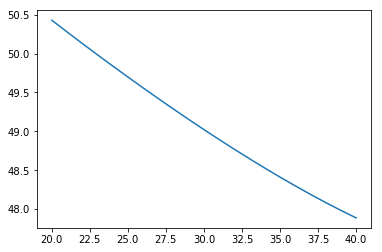

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(sweeps, drags)


In [25]:
model = Model(induced_matrix=Model.induced_matrix_bound_all,
        stations=10,
        speed=10,
        sweep=25.0,
        span=10,
        moment_coeff=-0.00,
        billow=1.0,
        fatness=0.0, 
        twist=10.5,
        chord=1.1,
        alpha=27.6)
    
print(model.total_drag_estimate())

49.4186033582


In [57]:
# Make data.
X = np.arange(20, 30, 0.25)  # sweeps
Y = np.arange(8, 15, 0.25)   # speeds
mX, mY = np.meshgrid(X, Y) 

lZ = [ Model(induced_matrix=Model.induced_matrix_bound_all,
        stations=10,
        speed=y,
        sweep=x,
        span=10,
        moment_coeff=-0.00,
        billow=1.0,
        fatness=0.0, 
        twist=10.5,
        chord=1.1,
        alpha=27.6).total_drag_estimate() \
     for x, y in zip(mX.ravel(), mY.ravel()) ]


In [68]:
import numpy
Z = numpy.array(lZ).reshape(len(Y), len(X))

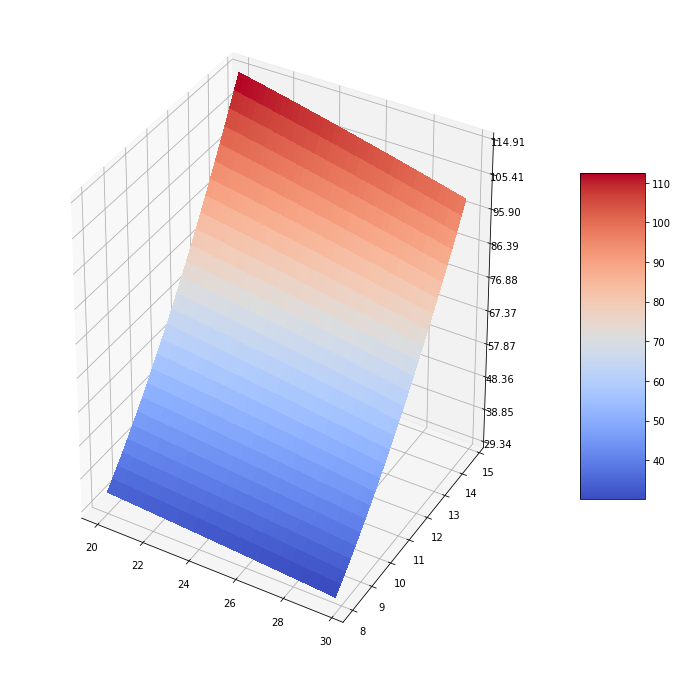

In [73]:
# from https://matplotlib.org/examples/mplot3d/surface3d_demo.html

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')


# Plot the surface.
surf = ax.plot_surface(mX, mY, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#ax.xlabel("sweep angle")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
